In [2]:
#python libraries
import os
import re
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

### DATA CLEANING

In [3]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", "Temperature"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)

            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)

            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()


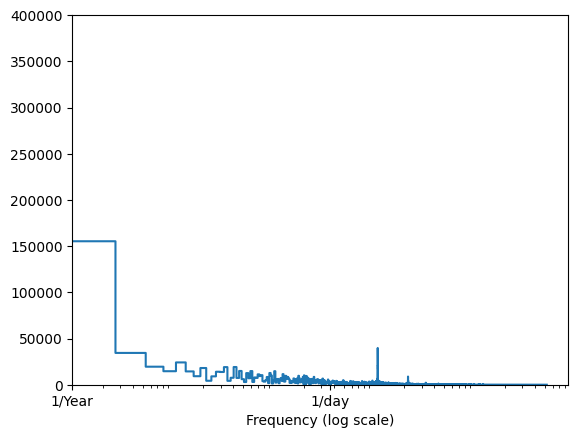

In [4]:
fft = np.fft.rfft(sensor_data['1OutdoorEntrance_temperature'])
f_per_dataset = np.arange(0, len(fft))

measurements_per_hour = 60/5
n_samples_h = len(sensor_data['1OutdoorEntrance_temperature'])/measurements_per_hour
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [5]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [6]:
sensor_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0BGuest_door,39166.0,0.731093,0.443397,0.000000,0.000000,1.000000e+00,1.000000,1.000000
0BRoom_temperature,39166.0,20.219920,2.777353,10.250000,18.800000,2.020000e+01,22.000000,27.450000
0BTCeiling_temperature,39166.0,20.493444,2.358416,15.100000,18.750000,2.048333e+01,22.100000,31.550000
0BTFloor_temperature,39166.0,19.880145,2.570392,14.150000,18.050000,1.975000e+01,21.650000,27.750000
0B_door,39166.0,0.159577,0.366218,0.000000,0.000000,0.000000e+00,0.000000,1.000000
0Bathroom_water,39166.0,0.003396,0.058175,0.000000,0.000000,0.000000e+00,0.000000,1.000000
1BathRoom_water,39166.0,0.113925,0.317725,0.000000,0.000000,0.000000e+00,0.000000,1.000000
1Entrance1_temperature,39166.0,23.061776,1.703731,15.300000,22.300000,2.345000e+01,24.250000,26.900000
1GuestRoom_temperature,39166.0,18.888458,3.133083,5.700000,17.650000,1.920000e+01,20.925000,28.200000
1MainBRHum_humidity_temperature,39166.0,38.371860,9.052182,19.000000,31.000000,3.700000e+01,45.000000,67.000000


In [7]:
print(f"Shape of DataFrame: {sensor_data.shape}")
sensor_data.head(2)

Shape of DataFrame: (39166, 35)


,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBRHum_humidity_temperature,...,2LivingRoomHumidifier_temperature_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-07 19:45:00+00:00,1.0,16.2,18.675,19.5,1.0,0.0,0.0,21.20,16.25,28.0,...,21.65,19.775000,1.0,21.15,-0.896873,0.442289,0.120129,0.992758,-0.433884,-0.900969
2022-01-07 20:00:00+00:00,1.0,16.2,18.700,19.6,1.0,0.0,0.0,21.15,16.35,28.0,...,21.65,19.733333,1.0,21.00,-0.866025,0.500000,0.120129,0.992758,-0.433884,-0.900969


### Neural Net

In [8]:
# We set a fixed seed for repeatability
random_seed = 12345  # This seed is also used in the pandas sample() method below
_ = torch.manual_seed(random_seed)

In [9]:
class Net(torch.nn.Module):

    def __init__(self, layers):
        super().__init__()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        assert len(layers) >= 2
        self.layers = layers

        linear_layers = []
        batch_norm_layers = []
        self.dropout = torch.nn.Dropout(0.25)

        for i in range(len(self.layers)-1):
            n_in = self.layers[i]
            n_out = self.layers[i+1]
            layer = torch.nn.Linear(n_in, n_out)

            #He initialization
            a = 1 if i == 0 else 2
            layer.weight.data = torch.randn((n_out, n_in))*np.sqrt(a/n_in)
            layer.bias.data = torch.zeros(n_out)

            linear_layers.append(layer)

            if i < len(self.layers) -2: batch_norm_layers.append(torch.nn.BatchNorm1d(n_out))

        self.linear_layers = torch.nn.ModuleList(linear_layers)
        self.batch_norm_layers = batch_norm_layers

        self.act = torch.nn.ReLU()

    def forward(self, input):
        x = input
        for i in range(len(self.linear_layers)-1):
            x = self.linear_layers[i](x)
            x = self.act(x)
        output_layer = self.linear_layers[-1]
        return output_layer(x)

    def get_num_params(self):
        return sum(param.numel() for param in self.parameters())
    
    def train(self, mode=True):
        super().train(mode)

        for layer in self.batch_norm_layers:
            layer.train(mode)

In [10]:
def train(
        net: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        n_epochs: int,
        lr: float,
        l2_reg: float,
        y_scaler: StandardScaler
) -> torch.nn.Module:
        # criterion = torch.nn.MSELoss(reduction='mean')
        criterion = torch.nn.MSELoss(reduction='sum')
        optimizer = torch.optim.Adam(net.parameters(), lr = lr)
        best_mse = np.inf
        patience = 50
        i_since_last_update = 0
        for epoch in range(n_epochs):
                for inputs, labels in train_loader:
                        optimizer.zero_grad()
                        outputs = net(inputs)
                        batch_mse = criterion(outputs, labels)
                        reg_loss = 0
                        for param in net.parameters():
                                reg_loss += param.abs().sum()
                        cost = batch_mse + l2_reg * reg_loss
                        cost.backward()
                        optimizer.step()
                
                mse_val = 0
                for inputs, labels in val_loader:
                        pred = y_scaler.inverse_transform(net(inputs).detach().numpy())
                        target = y_scaler.inverse_transform(labels)
                        row_len = len(target[0])
                        mse_val += np.sum(np.power(target-pred, 2))
                mse_val /= len(val_loader.dataset)*row_len
                #Early stopping
                if best_mse > mse_val:
                        net_to_return = copy.deepcopy(net)
                        i_since_last_update = 0
                        best_mse = mse_val
                else:
                        i_since_last_update += 1

                if i_since_last_update > patience:
                        print(f"Stopping early with mse={best_mse}")
                        return net_to_return
        
                print(f'Epoch: {epoch + 1}: Val MSE: {mse_val}')
        return net_to_return

In [11]:
temp_sensor_data = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].sort_index(axis=1)
x_dot = temp_sensor_data.drop("1OutdoorEntrance_temperature", axis=1).diff().drop(temp_sensor_data.index[0])

temp_and_door_sensor_data = pd.merge(sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')],
    sensor_data.loc[:, sensor_data.columns.str.endswith('door')],
    on="timestamp").sort_index(axis=1)

use_all_sensors = True
if use_all_sensors:
    x = sensor_data.drop(sensor_data.index[0])
else:
    x = temp_and_door_sensor_data.drop(temp_sensor_data.index[0])

shuffle_data = True
if shuffle_data:
    shuffled_timestamp = np.random.RandomState(seed=random_seed).permutation(x.index)
    x_dot = x_dot.reindex(shuffled_timestamp)
    x = x.reindex(shuffled_timestamp)
    

n_train = int(x.shape[0]*0.8)
n_val = int(x.shape[0]*0.1)
n_test = x.shape[0] - n_train - n_val

y_train_df = x_dot.iloc[:n_train]
x_train_df = x.iloc[:n_train]

n_y_vars = y_train_df.shape[1]
n_x_vars = x_train_df.shape[1]

y_val_df = x_dot.iloc[n_train:n_train+n_val]
x_val_df = x.iloc[n_train:n_train+n_val]

y_test_df = x_dot.iloc[n_train+n_val:]
x_test_df = x.iloc[n_train+n_val:]

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_norm = x_scaler.fit_transform(x_train_df)
x_val_norm = x_scaler.transform(x_val_df)
x_test_norm = x_scaler.transform(x_test_df)

transform_y = True
if transform_y:
    y_train_np = y_scaler.fit_transform(y_train_df)
    y_val_np = y_scaler.transform(y_val_df)
    y_test_np = y_scaler.transform(y_test_df)
else:
    y_train_np = y_train_df.values
    y_val_np = y_val_df.values
    y_test_np = y_test_df.values


print(f"Shape of x_train = {x_train_df.shape}, Shape of x_val = {x_val_df.shape}, Shape of x_test = {x_test_df.shape}")
print(f"Shape of y_train = {y_train_df.shape}, Shape of y_val = {y_val_df.shape}, Shape of y_test = {y_test_df.shape}")

Shape of x_train = (31332, 35), Shape of x_val = (3916, 35), Shape of x_test = (3917, 35)
Shape of y_train = (31332, 19), Shape of y_val = (3916, 19), Shape of y_test = (3917, 19)


In [12]:
y_train = torch.from_numpy(y_train_np).to(torch.float)
x_train = torch.from_numpy(x_train_norm).to(torch.float)

y_val = torch.from_numpy(y_val_np).to(torch.float)
x_val = torch.from_numpy(x_val_norm).to(torch.float)

y_test = torch.from_numpy(y_test_np).to(torch.float)
x_test = torch.from_numpy(x_test_norm).to(torch.float)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1048, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(x_val), shuffle=False)

In [13]:
layers = [x_train.shape[1], 128, 128, 128, len(y_train_df.columns)]
net = Net(layers)


print(f"Layers: {layers}")
print(f"Number of model parameters: {net.get_num_params()}")

n_epochs = 10000
lr = 1e-3
l2_reg = 1e-9
net = train(net, train_loader, val_loader, n_epochs, lr, l2_reg, y_scaler)

Layers: [35, 128, 128, 128, 19]
Number of model parameters: 40083
Epoch: 1: Val MSE: 0.08335142832379415
Epoch: 2: Val MSE: 0.08106678372216747
Epoch: 3: Val MSE: 0.07982491348561921
Epoch: 4: Val MSE: 0.07867864755853361
Epoch: 5: Val MSE: 0.07754244442598554
Epoch: 6: Val MSE: 0.07696295753675612
Epoch: 7: Val MSE: 0.07637344963194717
Epoch: 8: Val MSE: 0.07587258029667568
Epoch: 9: Val MSE: 0.07559158098374516
Epoch: 10: Val MSE: 0.0752717798854798
Epoch: 11: Val MSE: 0.07493826103443983
Epoch: 12: Val MSE: 0.0744970067855382
Epoch: 13: Val MSE: 0.07425413476933922
Epoch: 14: Val MSE: 0.0739796662566472
Epoch: 15: Val MSE: 0.07354040157650787
Epoch: 16: Val MSE: 0.07321080596861347
Epoch: 17: Val MSE: 0.07304380785227525
Epoch: 18: Val MSE: 0.07254516685723271
Epoch: 19: Val MSE: 0.07278531566621924
Epoch: 20: Val MSE: 0.07233134617500613
Epoch: 21: Val MSE: 0.07185207548455713
Epoch: 22: Val MSE: 0.07183374076740452
Epoch: 23: Val MSE: 0.0714610716019945
Epoch: 24: Val MSE: 0.07160

In [14]:
print(net)

Net(
  (dropout): Dropout(p=0.25, inplace=False)
  (linear_layers): ModuleList(
    (0): Linear(in_features=35, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=19, bias=True)
  )
  (act): ReLU()
)


In [15]:
# Predict on validation data
pred_val_inv = y_scaler.inverse_transform(net(x_val).detach())
# pred_val = torch.from_numpy(pred_val).to(torch.float)
y_val_inv = y_scaler.inverse_transform(y_val)

# Compute MSE, MAE and MAPE on validation data
print('Error on validation data')

mse_val = np.mean(np.power((pred_val_inv - y_val_inv), 2))
print(f'MSE: {mse_val.item()}')

mae_val = np.mean(np.abs(pred_val_inv - y_val_inv))
print(f'MAE: {mae_val.item()}')

# mape_val = 100*np.mean(np.abs(np.divide(pred_val_inv - y_val_inv, y_val_inv)))
# print(f'MAPE: {mape_val.item()} %')

Error on validation data
MSE: 0.06980494337364497
MAE: 0.10990884571605496


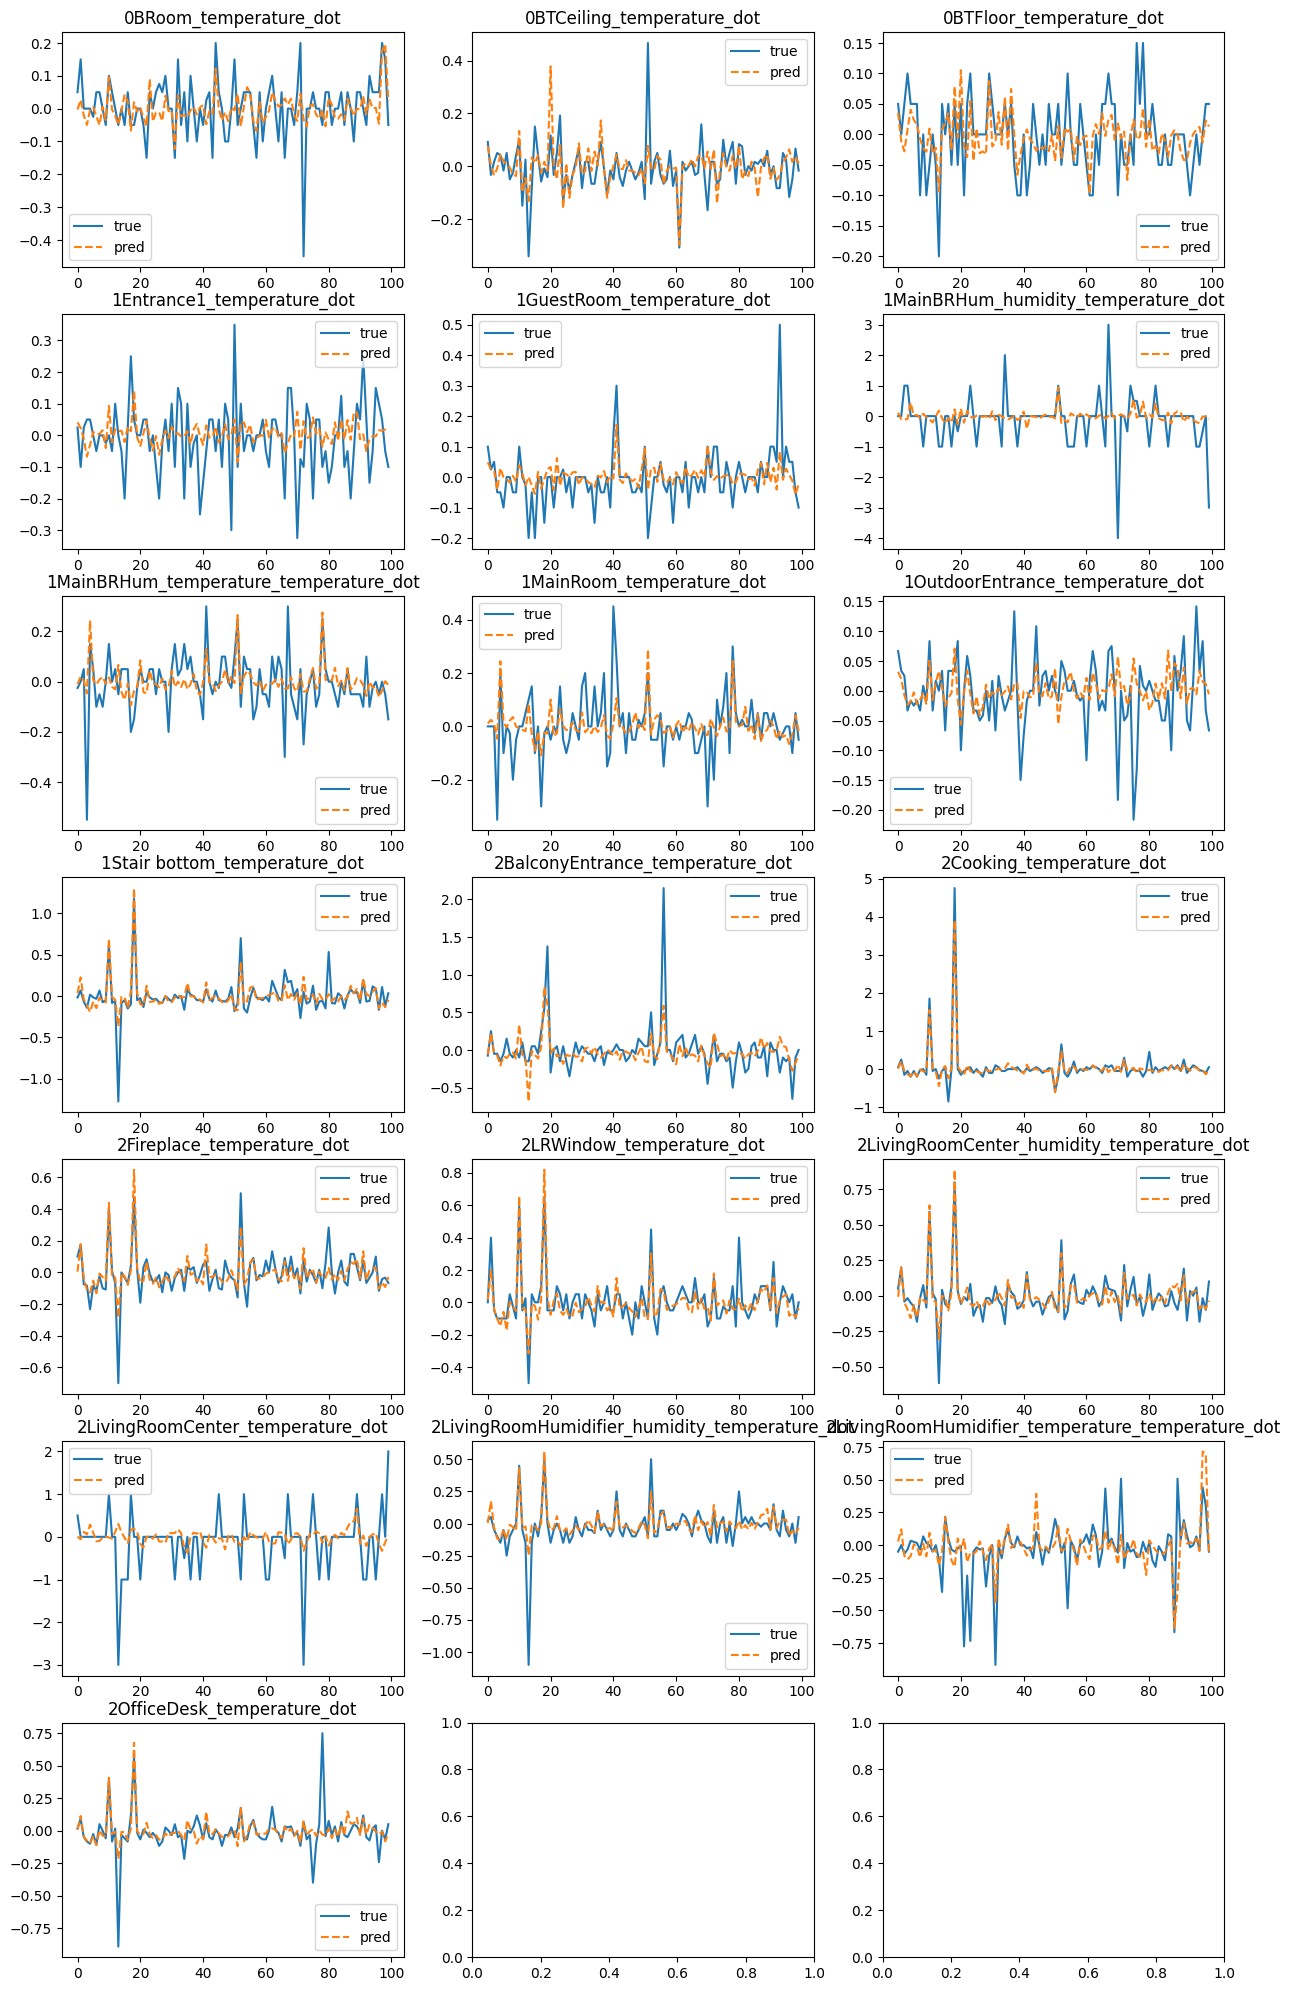

In [16]:
net.eval()
pred_train = y_scaler.inverse_transform(net(x_train).detach().numpy())
true_train = y_scaler.inverse_transform(y_train_np)
net.train()

fig,ax = plt.subplots(7,3,figsize=(15,25))
for i in range(y_train.shape[1]):
    ax[i//3, i%3].plot(true_train[:100, i], label="true")
    ax[i//3, i%3].plot(pred_train[:100, i], '--', label="pred")
    ax[i//3, i%3].set_title(f"{temp_sensor_data.columns[i]}_dot")
    ax[i//3, i%3].legend()

In [17]:
def rolling_forecast(model, x0, doors, temp, x_scaler, y_scaler, n):
    model.eval()
    
    x_hat = x0

    current_state = pd.merge(x0, pd.merge(temp.iloc[[0]], doors.iloc[[0]], on="timestamp"), on="timestamp").sort_index(axis=1)
    for i in range(n-1):
        prediction = model(torch.from_numpy(x_scaler.transform(current_state)).to(torch.float))
        prediction = y_scaler.inverse_transform(prediction.detach().numpy())

        new_val = {key: (d_dt + prev) for key, d_dt, prev in zip(x_hat.columns, prediction.flatten(), x_hat.iloc[i].values)}
        new_val["timestamp"] = temp.reset_index()["timestamp"][i+1]

        x_n = pd.DataFrame([new_val])
        x_hat = pd.concat([x_hat.reset_index(), x_n]).set_index("timestamp")

        current_state = pd.merge(x_n, pd.merge(temp.iloc[[i+1]], doors.iloc[[i+1]], on="timestamp"), on="timestamp").set_index("timestamp").sort_index(axis=1)

    model.train()
    return x_hat